In [1]:
import numpy as np
import os

# plotting
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,
    'axes.labelsize': 30,
    'axes.titlesize': 30,
    'font.size': 30,
    'legend.fontsize': 10,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': True,
    'font.family': 'serif',
}
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update(params)
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from dream_utils import DREAM

# DREAM Utility Class

Interfacing with the DREAM database files with the DREAM object in `dream_utils.py`.

## Reading in the data

The only necessary argument for the DREAM object is the location of the desired dataset. I'm using the dataset from the 2011 J Neurophys paper by Stevenson et al. 

In [2]:
data_path = os.path.join('stevenson', 'data', 'Stevenson_2011_e1.mat')
#data_path = os.path.join('flint', 'data', 'Flint_2012_e2.mat')
dream = DREAM(data_path=data_path)

The DREAM object automatically calculates quantities of interest, like the number of subjects, trials, and number of neurons.

In [3]:
print('Number of Subjects: %s' %dream.n_subjects)
print('Number of Trials for Each Subject:', dream.n_trials)
print('Number of Neurons for Each Subject:', dream.n_neurons)

Number of Subjects: 2
Number of Trials for Each Subject: [194, 362]
Number of Neurons for Each Subject: [196, 180]


## Subject and Trial Structs

The data is stored in Matlab struct objects, which we've opened with scipy. You can access these objects directly using the corresponding function. 

In [4]:
print('Subject 0: ', dream.get_subject(subject_idx=0))
print('Subject 0, Trial 0: ', dream.get_trial(subject_idx=0, trial_idx=0))

Subject 0:  <scipy.io.matlab.mio5_params.mat_struct object at 0x11052f0f0>
Subject 0, Trial 0:  <scipy.io.matlab.mio5_params.mat_struct object at 0x11052f828>


## Accessing Useful Quantities

In the following example, we'll look at a random trial. We'll observe the chosen target and how the monkey's hand position moves during the trial. The `plot_trial` function highlights the chosen target and the hand position, showing increasingly dark colors for later time points during the trial.

First, we'll tag when the stimulus onset is. We can do this with the `get_stim_onset_for_trial` function. 

Then, we'll need to identify the hand position coordinates at this timestamp. We'll get the hand positions with the `get_hand_pos_for_trial` function.

Lastly, we'll add the movement onset, which is defined by the relevant function parameters.

In [5]:
# choose a subject and trial to operate on
subject_idx = 0
trial_idx = 129

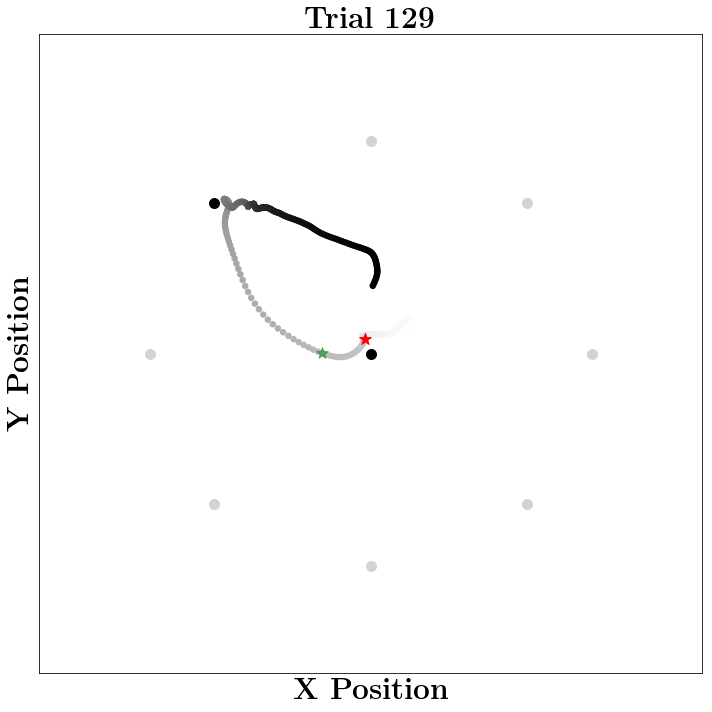

In [9]:
# get initial plot
ax = dream.plot_trial(subject_idx=subject_idx, trial_idx=trial_idx)
# get stim onset times
time_idx, timestamp, target = dream.get_stim_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
hand_position = dream.get_hand_pos_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
# get coordinates at stim onset
hand_pos_stim_onset = hand_position[time_idx]
# plot the coordinates with a star
ax.scatter(hand_pos_stim_onset[0], hand_pos_stim_onset[1], marker='*', s=150, color='r', zorder=10)

# movement onset
_, _, hand_pos_movement_onset = dream.get_movement_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx, consecutive=5)
ax.scatter(hand_pos_movement_onset[0], hand_pos_movement_onset[1], marker='*', s=150, color='g', alpha=0.5, zorder=10)
plt.tight_layout()
plt.savefig('example_reach.pdf')

Thus, we can see the monkey start from the center target (or move there if it's still moving from the previous trial). When the target flashes on, it'll move to the prompted target, hold, and then head to the center.

Some trials have no off-center target flashed on: see below for an example. These trials are not particularly useful for tuning models.

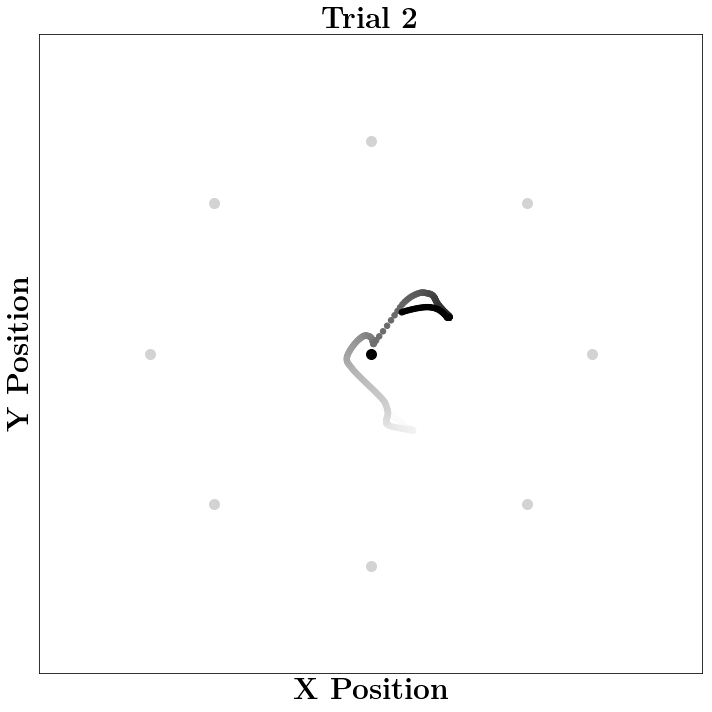

In [10]:
ax = dream.plot_trial(subject_idx=subject_idx, trial_idx=2)
plt.tight_layout()
plt.savefig('dud_trial.pdf')

Lastly, we can make a grid of all the trials with targets, hand positions, stimulus onset, and movement onset, and identified. This script will only work for Stevenson 2011, Subject 0.

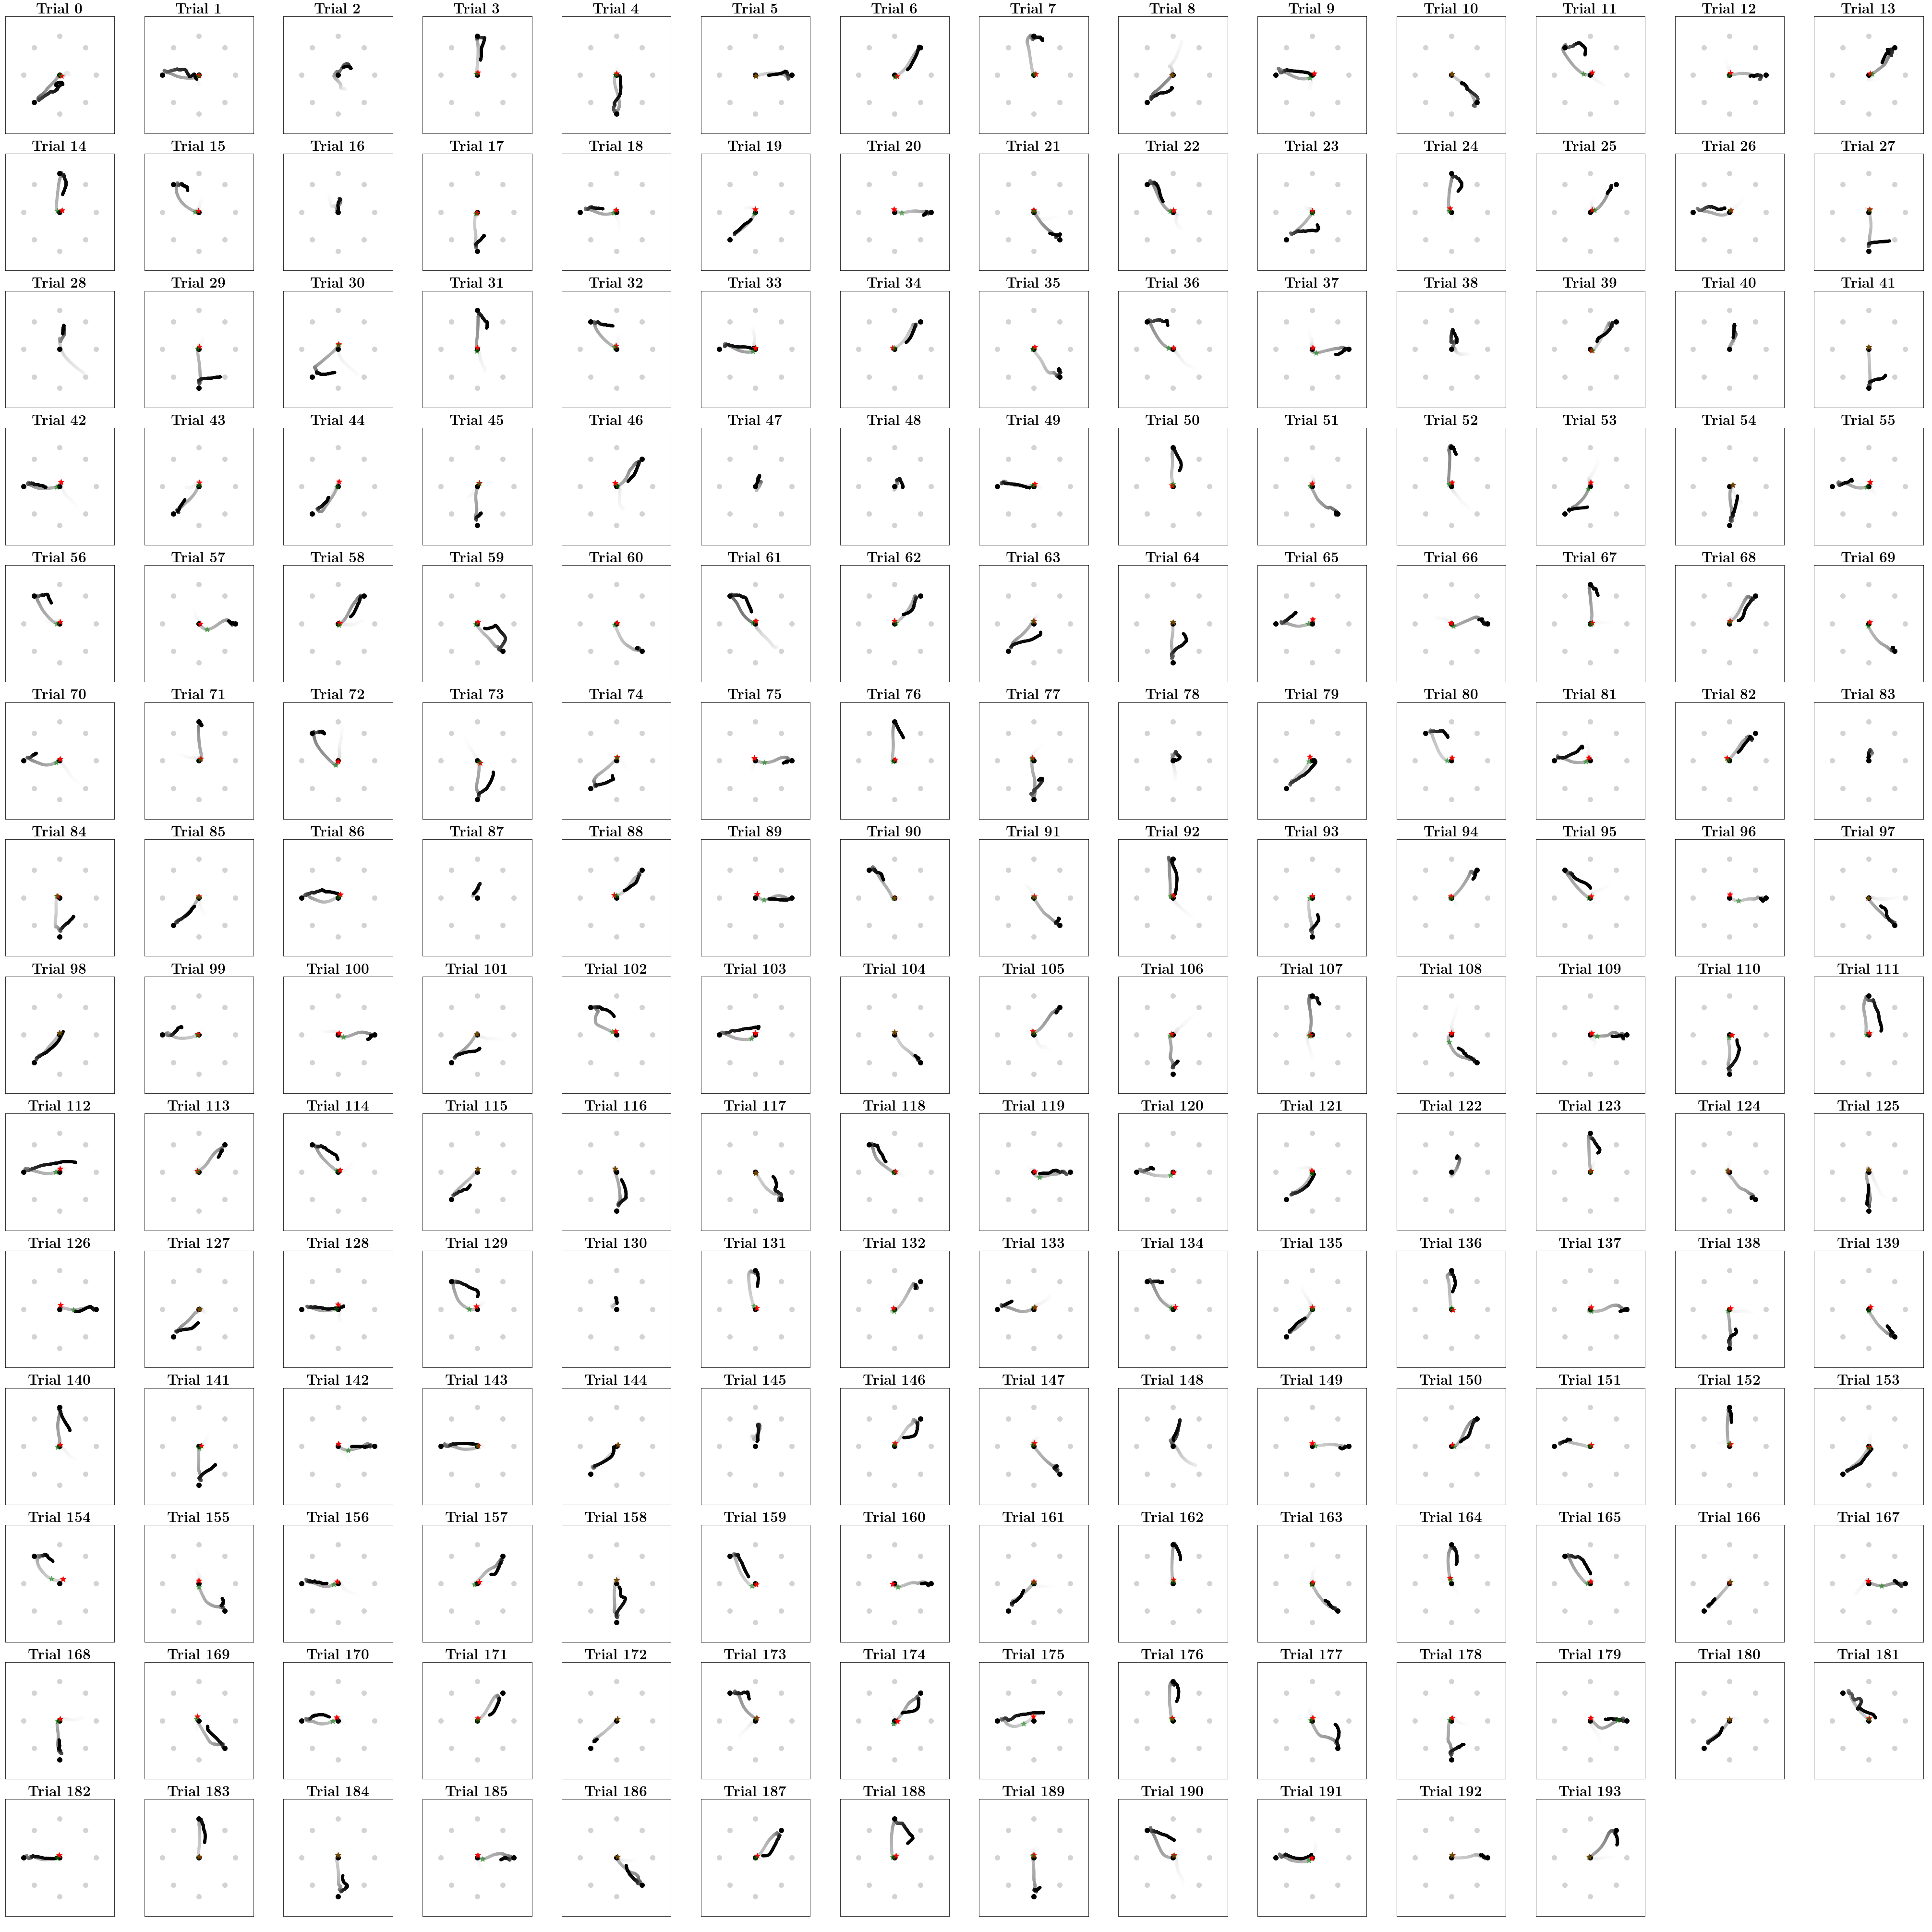

In [26]:
fig, axes = plt.subplots(14, 14, figsize=(56, 56))
for idx in range(194):
    trial_idx = idx
    ax = axes.ravel()[idx]
    # get initial plot
    dream.plot_trial(subject_idx=subject_idx, trial_idx=trial_idx, ax=ax)
    # get stim onset times
    stim_onset = dream.get_stim_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
    if stim_onset is not None:
        time_idx, timestamp, target = dream.get_stim_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
        hand_position = dream.get_hand_pos_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
        # get coordinates at stim onset
        hand_pos_stim_onset = hand_position[time_idx]
        # plot the coordinates with a star
        ax.scatter(hand_pos_stim_onset[0], hand_pos_stim_onset[1], marker='*', s=150, color='r', zorder=10)

        # movement onset
        _, _, hand_pos_movement_onset = dream.get_movement_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx, consecutive=5)
        ax.scatter(hand_pos_movement_onset[0], hand_pos_movement_onset[1], marker='*', s=150, color='g', alpha=0.5, zorder=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
axes.ravel()[-1].axis('off')
axes.ravel()[-2].axis('off')
plt.tight_layout()
plt.show()

## Getting Spikes

We can also get spiking activity for each trial, across all sorted neurons. Using the `get_spikes_for_trial` function, we can plot a spike raster for the neural population on a given trial.

Notice in the spike raster that many neurons are silent.

In [17]:
subject_idx = 0
trial_idx = 80

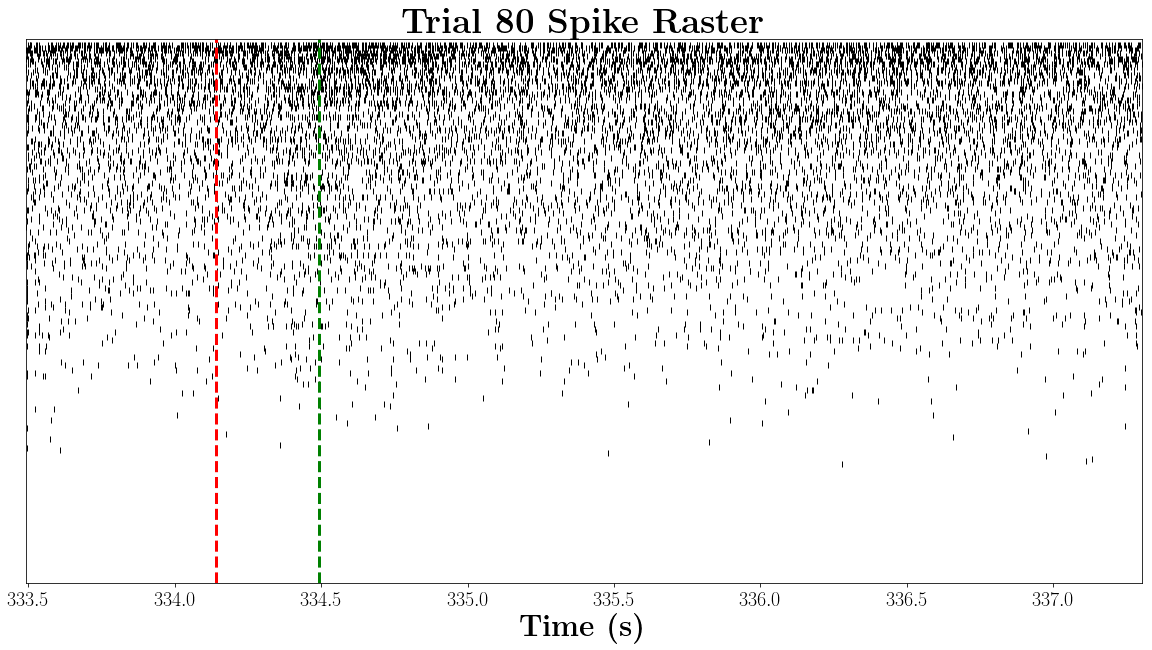

In [18]:
# grab spike dictionary for neural population
spikes = dream.get_spikes_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
# grab stim onset time
time_idx, timestamp, _  = dream.get_stim_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
# grab movement onset time
_, movement_onset_time, _ = dream.get_movement_onset_for_trial(subject_idx=subject_idx, trial_idx=trial_idx, consecutive=5)
# let's sort the neurons from least active to most active
n_spikes = [spikes[neuron_id].size for neuron_id in spikes.keys()]
sorted_ids = np.argsort(n_spikes)
# get timestamps
timestamps = dream.get_timestamps_for_trial(subject_idx=subject_idx, trial_idx=trial_idx)
# plot spike raster
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
# iterate over neurons
for y_idx, neuron_id in enumerate(sorted_ids):
    spike_times = spikes[neuron_id]
    tags = np.repeat(y_idx, spike_times.size)
    ax.scatter(spike_times, tags, color = 'k', marker='|', linewidth=1)
# plot stim onset time
ax.axvline(timestamp, linestyle='--', color='r', linewidth=3)
ax.axvline(movement_onset_time, linestyle='--', color='g', linewidth=3)
# set time bounds using timestamps
ax.set_xlim([timestamps[0], timestamps[-1]])
# set neuron bounds using neuron coun
ax.set_ylim([0, dream.n_neurons[subject_idx] + 1])
# beautify plot in other ways
ax.set_facecolor('white')
for spine in ax.spines:
    ax.spines[spine].set_edgecolor('k')
ax.set_yticklabels([])
ax.set_yticks([])
ax.tick_params(labelsize=20)
# labels
ax.set_xlabel(r'\textbf{Time (s)}', fontsize=30)
ax.set_title(r'\textbf{Trial %s Spike Raster}' %trial_idx, fontsize=35)
plt.show()